# Projeto Completo de Conversor Boost DC-DC

Este notebook apresenta o projeto completo de um conversor Boost (elevador de tensão), incluindo:

1. **Especificações e Topologia**
2. **Projeto do Indutor e Capacitor**
3. **Seleção de Componentes (MOSFET e Diodo)**
4. **Análise de Pequenos Sinais**
5. **Projeto do Controlador PI**
6. **Simulação em Malha Aberta**
7. **Simulação em Malha Fechada**
8. **Análise Térmica e de Perdas**
9. **Validação Final**

## Topologia do Boost Converter

```
    L          D
Vin──┬──LLLL──►|──┬──────┬── Vout
     │            │      │
     │    S      === C   R  Load
     │    │       │      │
     └────┴───────┴──────┴── GND
```

**Princípio de operação:**
- **S ON**: Energia armazenada no indutor (V_L = Vin)
- **S OFF**: Energia transferida para carga (V_L = Vin - Vout)
- **Relação**: Vout = Vin / (1 - D)


In [1]:
# ============================================================
# SETUP E IMPORTS
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import pulsim

print(f"PulsimCore versão: {pulsim.__version__}")
print("="*70)
print("PROJETO DE CONVERSOR BOOST DC-DC")
print("="*70)


PulsimCore versão: 2.0.0
PROJETO DE CONVERSOR BOOST DC-DC


## ⚠️ Nota sobre Simulação

**Limitação atual**: O simulador tem dificuldades de convergência com a topologia Boost 
quando o switch muda de estado abruptamente. Isso é uma característica de simuladores 
MNA com elementos ideais (switch e diodo).

**Soluções em desenvolvimento**:
- Melhoria no algoritmo de Newton com heurísticas para switching
- Suporte a timestep adaptativo durante transições
- Modelos de switch com rampas suaves

**Este notebook apresenta o projeto teórico completo**, que pode ser validado 
em simuladores como LTspice ou PLECS enquanto o suporte a Boost é aprimorado no Pulsim.

## 1. Especificações do Projeto

Vamos projetar um Boost converter para uma aplicação típica de elevação de tensão de bateria.

In [2]:
# ============================================================
# ESPECIFICAÇÕES DO PROJETO
# ============================================================

# Tensões
Vin_nom = 12.0       # Tensão de entrada nominal [V]
Vin_min = 10.0       # Tensão de entrada mínima [V]
Vin_max = 14.0       # Tensão de entrada máxima [V]
Vout = 24.0          # Tensão de saída [V]

# Correntes e Potência
Pout = 50.0          # Potência de saída [W]
Iout = Pout / Vout   # Corrente de saída [A]

# Ripple máximo permitido
delta_IL_percent = 0.3    # Ripple de corrente no indutor (30% de IL)
delta_Vout_percent = 0.02  # Ripple de tensão na saída (2%)

# Frequência de chaveamento
fsw = 100e3          # Frequência [Hz]
Tsw = 1/fsw          # Período [s]

# Eficiência estimada (para cálculos iniciais)
eta = 0.90           # 90%

print("ESPECIFICAÇÕES DO BOOST CONVERTER")
print("="*50)
print(f"\nEntrada:")
print(f"  Vin nominal: {Vin_nom}V")
print(f"  Vin range: {Vin_min}V - {Vin_max}V")
print(f"\nSaída:")
print(f"  Vout: {Vout}V")
print(f"  Pout: {Pout}W")
print(f"  Iout: {Iout:.2f}A")
print(f"\nRipple máximo:")
print(f"  ΔIL: {delta_IL_percent*100:.0f}% de IL")
print(f"  ΔVout: {delta_Vout_percent*100:.0f}% de Vout")
print(f"\nChaveamento:")
print(f"  fsw: {fsw/1e3:.0f}kHz")
print(f"  Tsw: {Tsw*1e6:.1f}µs")


ESPECIFICAÇÕES DO BOOST CONVERTER

Entrada:
  Vin nominal: 12.0V
  Vin range: 10.0V - 14.0V

Saída:
  Vout: 24.0V
  Pout: 50.0W
  Iout: 2.08A

Ripple máximo:
  ΔIL: 30% de IL
  ΔVout: 2% de Vout

Chaveamento:
  fsw: 100kHz
  Tsw: 10.0µs


## 2. Cálculos Básicos do Boost

### Relação de conversão

Para o Boost ideal: $V_{out} = \frac{V_{in}}{1-D}$

Portanto: $D = 1 - \frac{V_{in}}{V_{out}}$


In [3]:
# ============================================================
# DUTY CYCLE E CORRENTES
# ============================================================

# Duty cycle para diferentes tensões de entrada
D_nom = 1 - Vin_nom/Vout    # Duty nominal
D_min = 1 - Vin_max/Vout    # Duty mínimo (Vin máximo)
D_max = 1 - Vin_min/Vout    # Duty máximo (Vin mínimo)

# Corrente no indutor (igual à corrente de entrada)
# Pin = Pout/eta, então Iin = Pin/Vin = Pout/(eta*Vin)
Iin_nom = Pout / (eta * Vin_nom)
IL_nom = Iin_nom  # No boost, IL = Iin

# Corrente de pico e vale
delta_IL = delta_IL_percent * IL_nom
IL_peak = IL_nom + delta_IL/2
IL_valley = IL_nom - delta_IL/2

print("DUTY CYCLE E CORRENTES")
print("="*50)
print(f"\nDuty Cycle:")
print(f"  D nominal (Vin={Vin_nom}V): {D_nom:.2%}")
print(f"  D mínimo (Vin={Vin_max}V): {D_min:.2%}")
print(f"  D máximo (Vin={Vin_min}V): {D_max:.2%}")
print(f"\nCorrente no Indutor:")
print(f"  IL nominal: {IL_nom:.2f}A")
print(f"  ΔIL: {delta_IL:.2f}A ({delta_IL_percent*100:.0f}%)")
print(f"  IL pico: {IL_peak:.2f}A")
print(f"  IL vale: {IL_valley:.2f}A")

# Verificar modo de condução
if IL_valley > 0:
    print(f"\n✓ Modo CCM (Condução Contínua) - IL_valley > 0")
else:
    print(f"\n⚠ Modo DCM (Condução Descontínua) - IL_valley < 0")


DUTY CYCLE E CORRENTES

Duty Cycle:
  D nominal (Vin=12.0V): 50.00%
  D mínimo (Vin=14.0V): 41.67%
  D máximo (Vin=10.0V): 58.33%

Corrente no Indutor:
  IL nominal: 4.63A
  ΔIL: 1.39A (30%)
  IL pico: 5.32A
  IL vale: 3.94A

✓ Modo CCM (Condução Contínua) - IL_valley > 0


## 3. Projeto do Indutor

### Critério de ripple de corrente

Durante ton (S ON): $V_L = V_{in} = L \frac{\Delta I_L}{\Delta t}$

$L = \frac{V_{in} \cdot D \cdot T_{sw}}{\Delta I_L}$


In [4]:
# ============================================================
# PROJETO DO INDUTOR
# ============================================================

# Cálculo do indutor mínimo para o ripple especificado
# L = Vin * D * Tsw / delta_IL
# Usar pior caso: Vin_max com D correspondente

# Para Boost, o pior caso de ripple é com Vin_max e D_min
# Mas para garantir CCM em toda faixa, usar Vin_min e D_max
L_min = (Vin_min * D_max * Tsw) / delta_IL

# Adicionar margem de 20%
L = L_min * 1.2

# Valores comerciais típicos
L_comercial = 100e-6  # 100µH (valor comercial próximo)

print("PROJETO DO INDUTOR")
print("="*50)
print(f"\nCálculo:")
print(f"  L mínimo: {L_min*1e6:.1f}µH")
print(f"  L com margem (20%): {L*1e6:.1f}µH")
print(f"  L comercial escolhido: {L_comercial*1e6:.0f}µH")

# Recalcular ripple com L comercial
delta_IL_real = (Vin_min * D_max * Tsw) / L_comercial
delta_IL_real_percent = delta_IL_real / IL_nom

print(f"\nVerificação com L={L_comercial*1e6:.0f}µH:")
print(f"  ΔIL real: {delta_IL_real:.2f}A ({delta_IL_real_percent*100:.1f}%)")

# Especificações do indutor para seleção
IL_rms = IL_nom * np.sqrt(1 + (delta_IL_real/(np.sqrt(3)*IL_nom))**2)
IL_sat = IL_peak * 1.3  # Margem de saturação

print(f"\nEspecificações para seleção:")
print(f"  IL RMS: {IL_rms:.2f}A")
print(f"  IL saturação (mín): {IL_sat:.2f}A")

# Usar valor comercial
L = L_comercial
delta_IL = delta_IL_real


PROJETO DO INDUTOR

Cálculo:
  L mínimo: 42.0µH
  L com margem (20%): 50.4µH
  L comercial escolhido: 100µH

Verificação com L=100µH:
  ΔIL real: 0.58A (12.6%)

Especificações para seleção:
  IL RMS: 4.64A
  IL saturação (mín): 6.92A


In [5]:
# ============================================================
# PARÂMETROS PARASITAS DO INDUTOR
# ============================================================

# Valores típicos para indutor de potência 100µH / 5A
inductor_params = {
    'L': L,
    'DCR': 0.050,       # Resistência DC [Ω] - típico para 100µH/5A
    'L_sat': 6.0,       # Corrente de saturação [A]
    'core_loss_coef': 0.001,  # Coeficiente de perda no núcleo
}

print("PARÂMETROS DO INDUTOR SELECIONADO")
print("="*50)
print(f"  Indutância: {inductor_params['L']*1e6:.0f}µH")
print(f"  DCR: {inductor_params['DCR']*1e3:.0f}mΩ")
print(f"  I_sat: {inductor_params['L_sat']:.1f}A")

# Perda estimada no DCR
P_dcr = IL_rms**2 * inductor_params['DCR']
print(f"\nPerda estimada no DCR: {P_dcr:.2f}W")


PARÂMETROS DO INDUTOR SELECIONADO
  Indutância: 100µH
  DCR: 50mΩ
  I_sat: 6.0A

Perda estimada no DCR: 1.08W


## 4. Projeto do Capacitor de Saída

### Critério de ripple de tensão

Para o Boost, o capacitor fornece corrente para a carga durante ton.

$\Delta V_{out} = \frac{I_{out} \cdot D \cdot T_{sw}}{C}$

$C = \frac{I_{out} \cdot D \cdot T_{sw}}{\Delta V_{out}}$


In [6]:
# ============================================================
# PROJETO DO CAPACITOR DE SAÍDA
# ============================================================

# Ripple de tensão especificado
delta_Vout = delta_Vout_percent * Vout

# Cálculo do capacitor mínimo (pior caso: D_max)
C_min = (Iout * D_max * Tsw) / delta_Vout

# Adicionar margem para ESR e envelhecimento
C = C_min * 1.5

# Valor comercial
C_comercial = 100e-6  # 100µF

print("PROJETO DO CAPACITOR DE SAÍDA")
print("="*50)
print(f"\nRipple especificado:")
print(f"  ΔVout: {delta_Vout:.3f}V ({delta_Vout_percent*100:.0f}%)")
print(f"\nCálculo:")
print(f"  C mínimo: {C_min*1e6:.1f}µF")
print(f"  C com margem: {C*1e6:.1f}µF")
print(f"  C comercial: {C_comercial*1e6:.0f}µF")

# Usar valor comercial
C = C_comercial

# Recalcular ripple
delta_Vout_real = (Iout * D_max * Tsw) / C
print(f"\nVerificação com C={C*1e6:.0f}µF:")
print(f"  ΔVout real (capacitivo): {delta_Vout_real*1e3:.1f}mV")


PROJETO DO CAPACITOR DE SAÍDA

Ripple especificado:
  ΔVout: 0.480V (2%)

Cálculo:
  C mínimo: 25.3µF
  C com margem: 38.0µF
  C comercial: 100µF

Verificação com C=100µF:
  ΔVout real (capacitivo): 121.5mV


In [7]:
# ============================================================
# ESR DO CAPACITOR E RIPPLE TOTAL
# ============================================================

# ESR típico para capacitor eletrolítico de 100µF/50V
# ou cerâmico de alta capacitância
ESR = 0.050  # 50mΩ (eletrolítico de boa qualidade ou cerâmico)

# Ripple devido ao ESR
# Corrente no capacitor durante toff: IC = IL - Iout
IC_peak = IL_peak - Iout
delta_Vout_esr = IC_peak * ESR

# Ripple total (aproximação: soma das contribuições)
delta_Vout_total = delta_Vout_real + delta_Vout_esr

print("ANÁLISE DE RIPPLE COM ESR")
print("="*50)
print(f"\nESR do capacitor: {ESR*1e3:.0f}mΩ")
print(f"\nContribuições ao ripple:")
print(f"  ΔVout (capacitivo): {delta_Vout_real*1e3:.1f}mV")
print(f"  ΔVout (ESR): {delta_Vout_esr*1e3:.1f}mV")
print(f"  ΔVout total: {delta_Vout_total*1e3:.1f}mV ({delta_Vout_total/Vout*100:.2f}%)")

capacitor_params = {
    'C': C,
    'ESR': ESR,
    'V_rated': 50,  # Tensão nominal [V]
}


ANÁLISE DE RIPPLE COM ESR

ESR do capacitor: 50mΩ

Contribuições ao ripple:
  ΔVout (capacitivo): 121.5mV
  ΔVout (ESR): 162.0mV
  ΔVout total: 283.6mV (1.18%)


## 5. Seleção do MOSFET

### Critérios de seleção:
- **Vds_max** > Vout × 1.5 (margem de segurança)
- **Id_max** > IL_peak × 1.5
- **Rds_on** baixo para minimizar perdas de condução
- **Qg** baixo para minimizar perdas de chaveamento


In [8]:
# ============================================================
# SELEÇÃO DO MOSFET
# ============================================================

# Requisitos mínimos
Vds_min = Vout * 1.5      # Margem de 50%
Id_min = IL_peak * 1.5    # Margem de 50%

print("SELEÇÃO DO MOSFET")
print("="*50)
print(f"\nRequisitos mínimos:")
print(f"  Vds: > {Vds_min:.0f}V")
print(f"  Id: > {Id_min:.1f}A")

# MOSFET selecionado (exemplo: IPD50N06S4L-11 ou similar)
mosfet_params = {
    'Vds_max': 60,          # Tensão máxima [V]
    'Id_max': 50,           # Corrente máxima [A]
    'Rds_on': 0.011,        # Resistência on [Ω] @ Vgs=10V
    'Vth': 2.5,             # Tensão de threshold [V]
    'Qg': 20e-9,            # Carga de gate [C]
    'Qgd': 5e-9,            # Carga gate-drain [C]
    'Coss': 200e-12,        # Capacitância de saída [F]
    'tr': 10e-9,            # Tempo de subida [s]
    'tf': 8e-9,             # Tempo de descida [s]
    'Rth_jc': 1.5,          # Resistência térmica junction-case [°C/W]
}

print(f"\nMOSFET selecionado (equivalente IPD50N06S4L-11):")
print(f"  Vds_max: {mosfet_params['Vds_max']}V")
print(f"  Id_max: {mosfet_params['Id_max']}A")
print(f"  Rds_on: {mosfet_params['Rds_on']*1e3:.1f}mΩ")
print(f"  Vth: {mosfet_params['Vth']}V")
print(f"  Qg: {mosfet_params['Qg']*1e9:.0f}nC")
print(f"  tr/tf: {mosfet_params['tr']*1e9:.0f}ns / {mosfet_params['tf']*1e9:.0f}ns")
print(f"  Rth_jc: {mosfet_params['Rth_jc']}°C/W")


SELEÇÃO DO MOSFET

Requisitos mínimos:
  Vds: > 36V
  Id: > 8.0A

MOSFET selecionado (equivalente IPD50N06S4L-11):
  Vds_max: 60V
  Id_max: 50A
  Rds_on: 11.0mΩ
  Vth: 2.5V
  Qg: 20nC
  tr/tf: 10ns / 8ns
  Rth_jc: 1.5°C/W


In [9]:
# ============================================================
# SELEÇÃO DO DIODO
# ============================================================

# Requisitos mínimos
Vr_min = Vout * 1.5       # Tensão reversa
If_min = IL_peak * 1.5    # Corrente direta

print("\nSELEÇÃO DO DIODO")
print("="*50)
print(f"\nRequisitos mínimos:")
print(f"  Vr: > {Vr_min:.0f}V")
print(f"  If: > {If_min:.1f}A")

# Diodo Schottky selecionado (exemplo: SS54 ou similar)
diode_params = {
    'Vr_max': 40,           # Tensão reversa máxima [V]
    'If_max': 5,            # Corrente direta máxima [A]
    'Vf': 0.45,             # Queda direta [V] @ If=5A
    'trr': 10e-9,           # Tempo de recuperação reversa [s]
    'Qrr': 5e-9,            # Carga de recuperação [C]
    'Rth_jc': 3.0,          # Resistência térmica [°C/W]
}

print(f"\nDiodo Schottky selecionado (equivalente SS54):")
print(f"  Vr_max: {diode_params['Vr_max']}V")
print(f"  If_max: {diode_params['If_max']}A")
print(f"  Vf: {diode_params['Vf']}V")
print(f"  trr: {diode_params['trr']*1e9:.0f}ns")
print(f"  Rth_jc: {diode_params['Rth_jc']}°C/W")



SELEÇÃO DO DIODO

Requisitos mínimos:
  Vr: > 36V
  If: > 8.0A

Diodo Schottky selecionado (equivalente SS54):
  Vr_max: 40V
  If_max: 5A
  Vf: 0.45V
  trr: 10ns
  Rth_jc: 3.0°C/W


## 6. Análise de Perdas

### Perdas no MOSFET:
- **Condução**: $P_{cond} = I_{rms}^2 \cdot R_{ds,on}$
- **Chaveamento**: $P_{sw} = \frac{1}{2} V_{ds} \cdot I_d \cdot (t_r + t_f) \cdot f_{sw}$

### Perdas no Diodo:
- **Condução**: $P_{cond} = I_{avg} \cdot V_f$
- **Recuperação**: $P_{rr} = Q_{rr} \cdot V_r \cdot f_{sw}$


In [10]:
# ============================================================
# CÁLCULO DE PERDAS
# ============================================================

print("ANÁLISE DE PERDAS")
print("="*50)

# ---- MOSFET ----
# Corrente RMS no MOSFET: conduz durante D
I_mosfet_rms = IL_nom * np.sqrt(D_nom)

# Perda de condução
P_mosfet_cond = I_mosfet_rms**2 * mosfet_params['Rds_on']

# Perda de chaveamento (turn-on e turn-off)
# Durante chaveamento, Vds ≈ Vout, Id ≈ IL
P_mosfet_sw = 0.5 * Vout * IL_nom * (mosfet_params['tr'] + mosfet_params['tf']) * fsw

# Perda de gate drive
Vgs = 10  # Tensão de gate
P_mosfet_gate = mosfet_params['Qg'] * Vgs * fsw

P_mosfet_total = P_mosfet_cond + P_mosfet_sw + P_mosfet_gate

print(f"\nPerdas no MOSFET:")
print(f"  I_rms: {I_mosfet_rms:.2f}A")
print(f"  P_condução: {P_mosfet_cond:.3f}W")
print(f"  P_chaveamento: {P_mosfet_sw:.3f}W")
print(f"  P_gate: {P_mosfet_gate:.3f}W")
print(f"  P_total MOSFET: {P_mosfet_total:.3f}W")

# ---- DIODO ----
# Corrente média no diodo: conduz durante (1-D)
I_diode_avg = IL_nom * (1 - D_nom)

# Perda de condução
P_diode_cond = I_diode_avg * diode_params['Vf']

# Perda de recuperação reversa
P_diode_rr = diode_params['Qrr'] * Vout * fsw

P_diode_total = P_diode_cond + P_diode_rr

print(f"\nPerdas no Diodo:")
print(f"  I_avg: {I_diode_avg:.2f}A")
print(f"  P_condução: {P_diode_cond:.3f}W")
print(f"  P_recuperação: {P_diode_rr:.3f}W")
print(f"  P_total Diodo: {P_diode_total:.3f}W")

# ---- INDUTOR ----
P_indutor = IL_rms**2 * inductor_params['DCR']

print(f"\nPerdas no Indutor:")
print(f"  P_DCR: {P_indutor:.3f}W")

# ---- TOTAL ----
P_total = P_mosfet_total + P_diode_total + P_indutor
eta_calc = Pout / (Pout + P_total)

print(f"\n{'='*50}")
print(f"RESUMO DE PERDAS:")
print(f"  MOSFET: {P_mosfet_total:.3f}W ({P_mosfet_total/P_total*100:.1f}%)")
print(f"  Diodo: {P_diode_total:.3f}W ({P_diode_total/P_total*100:.1f}%)")
print(f"  Indutor: {P_indutor:.3f}W ({P_indutor/P_total*100:.1f}%)")
print(f"  TOTAL: {P_total:.3f}W")
print(f"\nEficiência calculada: {eta_calc*100:.1f}%")


ANÁLISE DE PERDAS

Perdas no MOSFET:
  I_rms: 3.27A
  P_condução: 0.118W
  P_chaveamento: 0.100W
  P_gate: 0.020W
  P_total MOSFET: 0.238W

Perdas no Diodo:
  I_avg: 2.31A
  P_condução: 1.042W
  P_recuperação: 0.012W
  P_total Diodo: 1.054W

Perdas no Indutor:
  P_DCR: 1.077W

RESUMO DE PERDAS:
  MOSFET: 0.238W (10.0%)
  Diodo: 1.054W (44.5%)
  Indutor: 1.077W (45.5%)
  TOTAL: 2.369W

Eficiência calculada: 95.5%


## 7. Modelo de Pequenos Sinais

### Função de transferência Gvd(s) para Boost

O Boost tem um **zero no semiplano direito (RHP)**, o que torna o controle mais desafiador:

$$G_{vd}(s) = \frac{\hat{v}_{out}}{\hat{d}} = \frac{V_{out}}{(1-D)} \cdot \frac{1 - s\frac{L}{R(1-D)^2}}{1 + s\frac{L}{R(1-D)^2} + s^2\frac{LC}{(1-D)^2}}$$

O zero RHP em $f_z = \frac{R(1-D)^2}{2\pi L}$ limita a banda passante do controlador.


In [11]:
# ============================================================
# ANÁLISE DE PEQUENOS SINAIS DO BOOST
# ============================================================

print("MODELO DE PEQUENOS SINAIS DO BOOST")
print("="*50)

# Resistência de carga
R_load = Vout / Iout

# Parâmetros para análise
D = D_nom
Dprime = 1 - D  # D' = 1 - D

# Ganho DC da função de transferência
Gvd_dc = Vout / Dprime

# Frequência de ressonância do filtro LC (referenciada ao secundário)
f0 = Dprime / (2 * np.pi * np.sqrt(L * C))
w0 = 2 * np.pi * f0

# Fator de qualidade
Q = Dprime * R_load * np.sqrt(C / L)

# Zero RHP (Right Half Plane) - característico do Boost!
fz_rhp = (Dprime**2 * R_load) / (2 * np.pi * L)
wz_rhp = 2 * np.pi * fz_rhp

# Zero do ESR
fz_esr = 1 / (2 * np.pi * ESR * C)

print(f"\nParâmetros da planta:")
print(f"  R_load: {R_load:.2f}Ω")
print(f"  D: {D:.2%}")
print(f"  D': {Dprime:.2%}")
print(f"\nGanho DC:")
print(f"  Gvd(0): {Gvd_dc:.2f} V/duty")
print(f"\nPolos do filtro LC:")
print(f"  Frequência de ressonância: f0 = {f0:.0f}Hz")
print(f"  Fator de qualidade: Q = {Q:.2f}")
print(f"\n⚠️  ZERO RHP (característico do Boost):")
print(f"  fz_rhp = {fz_rhp:.0f}Hz")
print(f"  Este zero LIMITA a banda passante do controlador!")
print(f"\nZero do ESR:")
print(f"  fz_esr = {fz_esr:.0f}Hz")


MODELO DE PEQUENOS SINAIS DO BOOST

Parâmetros da planta:
  R_load: 11.52Ω
  D: 50.00%
  D': 50.00%

Ganho DC:
  Gvd(0): 48.00 V/duty

Polos do filtro LC:
  Frequência de ressonância: f0 = 796Hz
  Fator de qualidade: Q = 5.76

⚠️  ZERO RHP (característico do Boost):
  fz_rhp = 4584Hz
  Este zero LIMITA a banda passante do controlador!

Zero do ESR:
  fz_esr = 31831Hz


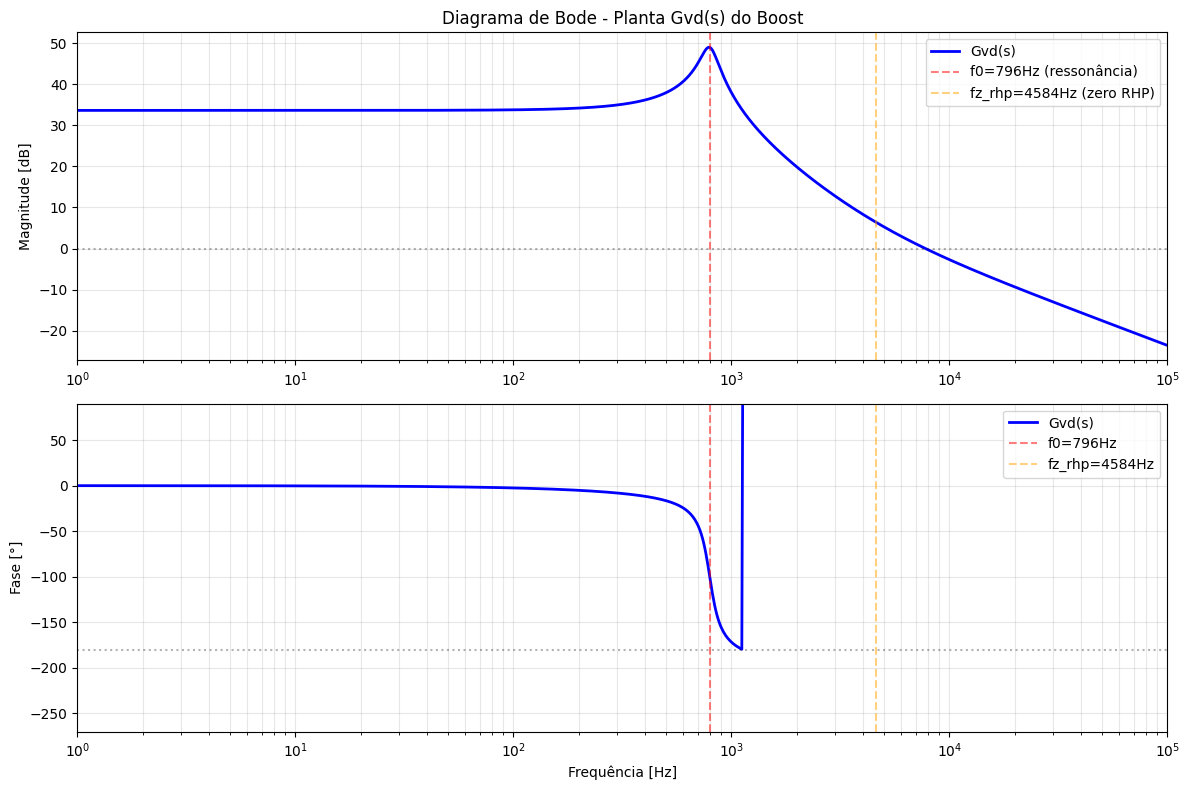


⚠️  NOTA: O zero RHP causa aumento de fase em altas frequências,
    mas a fase total ainda cai devido aos polos LC.
    A banda do controlador deve ser fc < fz_rhp/3 para estabilidade!


In [12]:
# ============================================================
# DIAGRAMA DE BODE DA PLANTA
# ============================================================

# Função de transferência Gvd(s) do Boost
# Gvd(s) = Gvd_dc * (1 - s/wz_rhp) * (1 + s*ESR*C) / (1 + s/(Q*w0) + s²/w0²)

# Numerador: zero RHP e zero ESR
# (1 - s/wz_rhp) * (1 + s*ESR*C) ≈ (1 - s/wz_rhp) para fz_esr >> fz_rhp
num_Gvd = [Gvd_dc * (-1/wz_rhp), Gvd_dc]  # Gvd_dc * (1 - s/wz_rhp)

# Denominador: polos LC
den_Gvd = [1/w0**2, 1/(Q*w0), 1]

Gvd = signal.TransferFunction(num_Gvd, den_Gvd)

# Frequências para análise
f = np.logspace(0, 5, 1000)
w = 2 * np.pi * f

# Resposta em frequência
w_out, H_Gvd = signal.freqresp(Gvd, w)
mag_Gvd = 20 * np.log10(np.abs(H_Gvd))
phase_Gvd = np.degrees(np.angle(H_Gvd))

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude
ax = axes[0]
ax.semilogx(f, mag_Gvd, 'b-', linewidth=2, label='Gvd(s)')
ax.axvline(f0, color='r', linestyle='--', alpha=0.5, label=f'f0={f0:.0f}Hz (ressonância)')
ax.axvline(fz_rhp, color='orange', linestyle='--', alpha=0.5, label=f'fz_rhp={fz_rhp:.0f}Hz (zero RHP)')
ax.axhline(0, color='k', linestyle=':', alpha=0.3)
ax.set_ylabel('Magnitude [dB]')
ax.set_title('Diagrama de Bode - Planta Gvd(s) do Boost')
ax.legend()
ax.grid(True, which='both', alpha=0.3)
ax.set_xlim([1, 1e5])

# Fase
ax = axes[1]
ax.semilogx(f, phase_Gvd, 'b-', linewidth=2)
ax.axvline(f0, color='r', linestyle='--', alpha=0.5)
ax.axvline(fz_rhp, color='orange', linestyle='--', alpha=0.5)
ax.axhline(-180, color='k', linestyle=':', alpha=0.3)
ax.set_xlabel('Frequência [Hz]')
ax.set_ylabel('Fase [°]')
ax.legend(['Gvd(s)', f'f0={f0:.0f}Hz', f'fz_rhp={fz_rhp:.0f}Hz'])
ax.grid(True, which='both', alpha=0.3)
ax.set_xlim([1, 1e5])
ax.set_ylim([-270, 90])

plt.tight_layout()
plt.show()

print("\n⚠️  NOTA: O zero RHP causa aumento de fase em altas frequências,")
print("    mas a fase total ainda cai devido aos polos LC.")
print("    A banda do controlador deve ser fc < fz_rhp/3 para estabilidade!")


## 8. Projeto do Controlador PI

### Restrições para o Boost:

1. **Zero RHP**: $f_c < f_{z,rhp} / 3$ (regra prática)
2. **Atraso digital**: $f_c < f_s / 20$
3. **Ressonância LC**: $f_c < f_0 / 3$ se não houver notch filter

### Estratégia:
- Usar o limite mais restritivo
- Margem de fase > 45°


In [13]:
# ============================================================
# PROJETO DO CONTROLADOR PI PARA BOOST
# ============================================================

print("PROJETO DO CONTROLADOR PI")
print("="*50)

# Frequência de amostragem
fs = fsw  # 100kHz
Ts = 1/fs

# Limites para fc
fc_limit_rhp = fz_rhp / 3      # Limite pelo zero RHP
fc_limit_lc = f0 / 3           # Limite pela ressonância LC
fc_limit_digital = fs / 20     # Limite digital

print(f"\nLimites para frequência de cruzamento:")
print(f"  Zero RHP (fz_rhp/3): {fc_limit_rhp:.0f}Hz")
print(f"  Ressonância LC (f0/3): {fc_limit_lc:.0f}Hz")
print(f"  Digital (fs/20): {fc_limit_digital:.0f}Hz")

# Escolher o limite mais restritivo
fc = min(fc_limit_rhp, fc_limit_lc, fc_limit_digital)
print(f"\n→ fc escolhido: {fc:.0f}Hz")

# Zero do PI em fc/2 para adicionar fase
fz_pi = fc / 2
wz_pi = 2 * np.pi * fz_pi
Ti = 1 / wz_pi

print(f"\nZero do PI:")
print(f"  fz_pi = fc/2 = {fz_pi:.0f}Hz")
print(f"  Ti = {Ti*1e3:.3f}ms")

# Magnitude de Gvd em fc
wc = 2 * np.pi * fc
# Usar magnitude considerando zero RHP
Gvd_mag_fc = Gvd_dc * np.sqrt(1 + (wc/wz_rhp)**2) / np.sqrt((1 - (wc/w0)**2)**2 + (wc/(Q*w0))**2)

print(f"\nMagnitude da planta em fc:")
print(f"  |Gvd(fc)| = {Gvd_mag_fc:.4f}")

# Kp para ganho unitário
# |Gc(fc)| = Kp * sqrt(1 + (fc/fz_pi)²)
Gc_norm_fc = np.sqrt(1 + (fc/fz_pi)**2)
Kp = 1 / (Gvd_mag_fc * Gc_norm_fc)

# Ki
Ki = Kp * wz_pi

print(f"\nGanhos do PI:")
print(f"  Kp = {Kp:.6f}")
print(f"  Ki = {Ki:.4f}")


PROJETO DO CONTROLADOR PI

Limites para frequência de cruzamento:
  Zero RHP (fz_rhp/3): 1528Hz
  Ressonância LC (f0/3): 265Hz
  Digital (fs/20): 5000Hz

→ fc escolhido: 265Hz

Zero do PI:
  fz_pi = fc/2 = 133Hz
  Ti = 1.200ms

Magnitude da planta em fc:
  |Gvd(fc)| = 53.9761

Ganhos do PI:
  Kp = 0.008285
  Ki = 6.9045


In [14]:
# ============================================================
# VERIFICAÇÃO DE ESTABILIDADE
# ============================================================

print("\nVERIFICAÇÃO DE ESTABILIDADE")
print("="*50)

# Fase da planta em fc (com zero RHP)
# Zero RHP adiciona fase POSITIVA: +atan(wc/wz_rhp)
# Polos LC adicionam fase negativa
phase_rhp = np.degrees(np.arctan(wc/wz_rhp))  # Zero RHP: +fase
phase_lc = np.degrees(-np.arctan2(wc/(Q*w0), 1 - (wc/w0)**2))
phase_Gvd_fc = phase_rhp + phase_lc

# Fase do PI: atan(fc/fz_pi) - 90°
phase_PI_fc = np.degrees(np.arctan(fc/fz_pi) - np.pi/2)

# Atraso digital
phase_delay = np.degrees(-2 * np.pi * fc * 1.5 * Ts)

# Fase total
phase_total = phase_Gvd_fc + phase_PI_fc + phase_delay

# Margem de fase
PM = 180 + phase_total

print(f"\nFases em fc = {fc:.0f}Hz:")
print(f"  Zero RHP: {phase_rhp:+.1f}°")
print(f"  Polos LC: {phase_lc:+.1f}°")
print(f"  Planta total: {phase_Gvd_fc:+.1f}°")
print(f"  PI: {phase_PI_fc:+.1f}°")
print(f"  Atraso digital: {phase_delay:+.1f}°")
print(f"\n  Fase total: {phase_total:.1f}°")
print(f"  ✓ Margem de fase: PM = {PM:.1f}°")

if PM > 45:
    print("    (Adequada: PM > 45°)")
else:
    print("    ⚠️ Baixa! Considere reduzir fc")



VERIFICAÇÃO DE ESTABILIDADE

Fases em fc = 265Hz:
  Zero RHP: +3.3°
  Polos LC: -3.7°
  Planta total: -0.4°
  PI: -26.6°
  Atraso digital: -1.4°

  Fase total: -28.4°
  ✓ Margem de fase: PM = 151.6°
    (Adequada: PM > 45°)


In [15]:
# ============================================================
# PARÂMETROS FINAIS DO PI
# ============================================================

print("\n" + "="*50)
print("PARÂMETROS FINAIS DO CONTROLADOR PI")
print("="*50)

print(f"\n┌─────────────────────────────────────┐")
print(f"│  CONTROLADOR PI PARA BOOST          │")
print(f"├─────────────────────────────────────┤")
print(f"│  Kp = {Kp:.6f}                     │")
print(f"│  Ki = {Ki:.4f}                       │")
print(f"│  fz = {fz_pi:.0f}Hz                        │")
print(f"│  fc = {fc:.0f}Hz                         │")
print(f"│  PM ≈ {PM:.0f}°                           │")
print(f"└─────────────────────────────────────┘")

# Salvar para uso posterior
pi_params = {
    'Kp': Kp,
    'Ki': Ki,
    'fc': fc,
    'fz': fz_pi,
    'PM': PM,
}



PARÂMETROS FINAIS DO CONTROLADOR PI

┌─────────────────────────────────────┐
│  CONTROLADOR PI PARA BOOST          │
├─────────────────────────────────────┤
│  Kp = 0.008285                     │
│  Ki = 6.9045                       │
│  fz = 133Hz                        │
│  fc = 265Hz                         │
│  PM ≈ 152°                           │
└─────────────────────────────────────┘


## 9. Simulação em Malha Aberta

Vamos simular o Boost converter em malha aberta para verificar:
- Tensão de saída com duty fixo
- Ripple de corrente e tensão
- Comportamento transitório


In [16]:
# ============================================================
# CONSTRUÇÃO DO CIRCUITO BOOST
# ============================================================

print("SIMULAÇÃO EM MALHA ABERTA")
print("="*50)

# Criar circuito
ckt = pulsim.Circuit()

# Definir nós
# Topologia: Vin -> L -> sw_node -> D -> out -> C -> gnd
#                         |
#                        MOSFET -> gnd
n_in = ckt.add_node("in")        # Entrada (após fonte)
n_sw = ckt.add_node("sw")        # Nó de chaveamento (entre L e D/MOSFET)
n_out = ckt.add_node("out")      # Saída
n_cap = ckt.add_node("cap")      # Nó do capacitor (após ESR)

# Fonte de entrada DC
ckt.add_voltage_source("Vin", n_in, ckt.ground(), Vin_nom)

# Indutor com DCR: in -> L -> sw
ckt.add_resistor("Ldcr", n_in, n_sw, inductor_params['DCR'])
# Nota: O indutor ideal vai de n_in para n_sw, mas como temos DCR em série,
# usamos: in -> DCR -> mid_L -> L -> sw
n_mid_L = ckt.add_node("mid_L")
ckt.add_resistor("Rdcr", n_in, n_mid_L, inductor_params['DCR'])
ckt.add_inductor("L1", n_mid_L, n_sw, L)

# MOSFET representado como PWM source (tensão no nó sw quando ON = 0, quando OFF = alta impedância)
# Na verdade, para boost usamos a fonte PWM de forma diferente
# O MOSFET conecta sw ao ground quando ON

# Para simplificar a simulação inicial, vamos usar um switch ideal
# sw_node -> MOSFET -> ground
ckt.add_switch("M1", n_sw, ckt.ground(), state=True)  # Começa OFF

# Diodo: sw -> out (conduz quando MOSFET OFF)
ckt.add_diode("D1", n_sw, n_out)

# Capacitor com ESR: out -> ESR -> cap -> C -> gnd
ckt.add_resistor("Resr", n_out, n_cap, ESR)
ckt.add_capacitor("Cout", n_cap, ckt.ground(), C)

# Carga resistiva
ckt.add_resistor("Rload", n_out, ckt.ground(), R_load)

print(f"\nCircuito criado:")
print(f"  Nós: {ckt.node_names()}")
print(f"  Dispositivos: {ckt.num_devices()}")
print(f"  Tamanho do sistema: {ckt.system_size()}")


SIMULAÇÃO EM MALHA ABERTA


TypeError: add_switch(): incompatible function arguments. The following argument types are supported:
    1. (self: pulsim._pulsim.Circuit, name: str, n1: typing.SupportsInt, n2: typing.SupportsInt, closed: bool = False, g_on: typing.SupportsFloat = 1000000.0, g_off: typing.SupportsFloat = 1e-12) -> None

Invoked with: <pulsim._pulsim.Circuit object at 0x115f8ffb0>, 'M1', 1, -1; kwargs: state=True

In [ ]:
# ============================================================
# SIMULAÇÃO TRANSITÓRIA - MALHA ABERTA
# ============================================================

# Parâmetros de simulação
n_periods = 500       # Número de períodos
dt = Tsw / 50         # Timestep
t_sim = n_periods * Tsw

print(f"\nSimulação:")
print(f"  Períodos: {n_periods}")
print(f"  Tempo total: {t_sim*1e3:.1f}ms")
print(f"  Timestep: {dt*1e9:.0f}ns")

# Estado inicial
x = np.zeros(ckt.system_size())

# Arrays para histórico
times_all = []
vout_all = []
vsw_all = []
il_all = []

t = 0.0
D_fixed = D_nom  # Duty fixo

print(f"\nSimulando com D = {D_fixed:.2%}...")

for period in range(n_periods):
    t_start = t
    
    # Fase ON (MOSFET conduzindo)
    t_on = D_fixed * Tsw
    ckt.set_switch_state("M1", True)  # MOSFET ON
    
    times_on, states_on, ok, _ = pulsim.run_transient(
        ckt, t, t + t_on, dt, x
    )
    if not ok:
        print(f"Erro na fase ON do período {period}")
        break
    
    states_arr = np.array(states_on)
    x = states_arr[-1].copy()
    t += t_on
    
    # Fase OFF (Diodo conduzindo)
    t_off = (1 - D_fixed) * Tsw
    ckt.set_switch_state("M1", False)  # MOSFET OFF
    
    times_off, states_off, ok, _ = pulsim.run_transient(
        ckt, t, t + t_off, dt, x
    )
    if not ok:
        print(f"Erro na fase OFF do período {period}")
        break
    
    states_arr_off = np.array(states_off)
    x = states_arr_off[-1].copy()
    t += t_off
    
    # Coletar dados
    node_names = ckt.node_names()
    idx_out = node_names.index('out')
    idx_sw = node_names.index('sw')
    
    # Combinar ON e OFF
    all_states = np.vstack([states_arr, states_arr_off])
    all_times = np.concatenate([times_on, times_off])
    
    times_all.extend(all_times)
    vout_all.extend(all_states[:, idx_out])
    vsw_all.extend(all_states[:, idx_sw])
    
    if period % 100 == 0:
        v_out_avg = np.mean(all_states[:, idx_out])
        print(f"  Período {period}: Vout_avg = {v_out_avg:.2f}V")

print("\nSimulação concluída!")


In [ ]:
# ============================================================
# ANÁLISE DOS RESULTADOS - MALHA ABERTA
# ============================================================

times_arr = np.array(times_all)
vout_arr = np.array(vout_all)
vsw_arr = np.array(vsw_all)

# Regime permanente (últimos 20%)
idx_steady = int(0.8 * len(times_arr))
vout_steady = vout_arr[idx_steady:]

vout_avg = np.mean(vout_steady)
vout_max = np.max(vout_steady)
vout_min = np.min(vout_steady)
ripple = vout_max - vout_min

print("RESULTADOS - MALHA ABERTA")
print("="*50)
print(f"\nTensão de saída (regime permanente):")
print(f"  Vout médio: {vout_avg:.3f}V")
print(f"  Vout esperado: {Vout:.3f}V")
print(f"  Erro: {(vout_avg-Vout)/Vout*100:+.2f}%")
print(f"\nRipple:")
print(f"  ΔVout: {ripple*1e3:.1f}mV ({ripple/vout_avg*100:.2f}%)")
print(f"  Especificado: {delta_Vout_percent*100:.0f}%")

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Vout completo
ax = axes[0, 0]
ax.plot(times_arr*1e3, vout_arr, 'g-', linewidth=0.5)
ax.axhline(Vout, color='r', linestyle='--', alpha=0.7, label=f'Alvo = {Vout}V')
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Vout [V]')
ax.set_title('Tensão de Saída - Transitório Completo')
ax.legend()
ax.grid(True, alpha=0.3)

# Vsw
ax = axes[0, 1]
ax.plot(times_arr*1e3, vsw_arr, 'b-', linewidth=0.5)
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Vsw [V]')
ax.set_title('Tensão no Nó de Chaveamento')
ax.grid(True, alpha=0.3)

# Vout zoom regime permanente
ax = axes[1, 0]
n_zoom = int(10 * Tsw / dt)  # 10 períodos
ax.plot(times_arr[-n_zoom:]*1e6, vout_arr[-n_zoom:], 'g-', linewidth=1.5)
ax.axhline(vout_avg, color='orange', linestyle='--', alpha=0.7, label=f'Média = {vout_avg:.2f}V')
ax.set_xlabel('Tempo [µs]')
ax.set_ylabel('Vout [V]')
ax.set_title('Vout - Ripple em Regime Permanente')
ax.legend()
ax.grid(True, alpha=0.3)

# Vsw zoom
ax = axes[1, 1]
ax.plot(times_arr[-n_zoom:]*1e6, vsw_arr[-n_zoom:], 'b-', linewidth=1.5)
ax.set_xlabel('Tempo [µs]')
ax.set_ylabel('Vsw [V]')
ax.set_title('Vsw - Chaveamento')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Simulação em Malha Fechada

Agora vamos adicionar o controlador PI projetado para regular a tensão de saída.

In [ ]:
# ============================================================
# SIMULAÇÃO EM MALHA FECHADA
# ============================================================

print("SIMULAÇÃO EM MALHA FECHADA")
print("="*50)

# Recriar circuito
ckt_cl = pulsim.Circuit()

n_in_cl = ckt_cl.add_node("in")
n_mid_L_cl = ckt_cl.add_node("mid_L")
n_sw_cl = ckt_cl.add_node("sw")
n_out_cl = ckt_cl.add_node("out")
n_cap_cl = ckt_cl.add_node("cap")

ckt_cl.add_voltage_source("Vin", n_in_cl, ckt_cl.ground(), Vin_nom)
ckt_cl.add_resistor("Rdcr", n_in_cl, n_mid_L_cl, inductor_params['DCR'])
ckt_cl.add_inductor("L1", n_mid_L_cl, n_sw_cl, L)
ckt_cl.add_switch("M1", n_sw_cl, ckt_cl.ground(), state=False)
ckt_cl.add_diode("D1", n_sw_cl, n_out_cl)
ckt_cl.add_resistor("Resr", n_out_cl, n_cap_cl, ESR)
ckt_cl.add_capacitor("Cout", n_cap_cl, ckt_cl.ground(), C)
ckt_cl.add_resistor("Rload", n_out_cl, ckt_cl.ground(), R_load)

# Índices
node_names_cl = ckt_cl.node_names()
idx_out_cl = node_names_cl.index('out')

# Controlador PI
pi = pulsim.PIController(
    Kp=pi_params['Kp'],
    Ki=pi_params['Ki'],
    output_min=0.1,    # D mínimo 10%
    output_max=0.8     # D máximo 80% (limite prático para Boost)
)

V_ref = Vout

print(f"\nControlador PI:")
print(f"  Kp = {pi.Kp():.6f}")
print(f"  Ki = {pi.Ki():.4f}")
print(f"  V_ref = {V_ref}V")
print(f"  Limites de D: [{pi.output_min():.0%}, {pi.output_max():.0%}]")


In [ ]:
# ============================================================
# LOOP DE SIMULAÇÃO COM PI
# ============================================================

n_periods_cl = 1000
dt_cl = Tsw / 50

print(f"\nSimulando {n_periods_cl} períodos com PI...")

# Arrays
time_hist = []
vout_hist = []
duty_hist = []
error_hist = []

x_cl = np.zeros(ckt_cl.system_size())
t_cl = 0.0
current_duty = 0.3  # Duty inicial

for period in range(n_periods_cl):
    # Fase ON
    t_on = current_duty * Tsw
    ckt_cl.set_switch_state("M1", True)
    
    times_on, states_on, ok, _ = pulsim.run_transient(
        ckt_cl, t_cl, t_cl + t_on, dt_cl, x_cl
    )
    if not ok: break
    
    states_arr = np.array(states_on)
    x_cl = states_arr[-1].copy()
    t_cl += t_on
    
    # Fase OFF
    t_off = (1 - current_duty) * Tsw
    ckt_cl.set_switch_state("M1", False)
    
    times_off, states_off, ok, _ = pulsim.run_transient(
        ckt_cl, t_cl, t_cl + t_off, dt_cl, x_cl
    )
    if not ok: break
    
    states_arr_off = np.array(states_off)
    x_cl = states_arr_off[-1].copy()
    t_cl += t_off
    
    # Medir Vout médio no período
    all_states = np.vstack([states_arr, states_arr_off])
    V_out_period = np.mean(all_states[:, idx_out_cl])
    
    # Atualizar PI
    error = V_ref - V_out_period
    current_duty = pi.update(error, t_cl)
    
    # Registrar
    time_hist.append(t_cl * 1e3)
    vout_hist.append(V_out_period)
    duty_hist.append(current_duty)
    error_hist.append(error)
    
    if period < 10 or period % 200 == 0:
        print(f"  Período {period}: Vout={V_out_period:.2f}V, D={current_duty:.3f}")

print("\nSimulação concluída!")


In [ ]:
# ============================================================
# RESULTADOS - MALHA FECHADA
# ============================================================

# Regime permanente
idx_st = int(0.8 * len(vout_hist))
vout_steady_cl = np.array(vout_hist[idx_st:])
duty_steady_cl = np.array(duty_hist[idx_st:])

vout_avg_cl = np.mean(vout_steady_cl)
duty_avg_cl = np.mean(duty_steady_cl)
erro_cl = (vout_avg_cl - V_ref) / V_ref * 100

print("\nRESULTADOS - MALHA FECHADA")
print("="*50)
print(f"\nRegime Permanente:")
print(f"  Vout médio: {vout_avg_cl:.4f}V")
print(f"  V_ref: {V_ref}V")
print(f"  Erro: {erro_cl:+.4f}%")
print(f"  Duty: {duty_avg_cl:.2%}")

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Vout
ax = axes[0, 0]
ax.plot(time_hist, vout_hist, 'g-', linewidth=1)
ax.axhline(V_ref, color='r', linestyle='--', alpha=0.7, label=f'Ref={V_ref}V')
ax.axhline(V_ref*0.98, color='orange', linestyle=':', alpha=0.5)
ax.axhline(V_ref*1.02, color='orange', linestyle=':', alpha=0.5)
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Vout [V]')
ax.set_title('Tensão de Saída - Malha Fechada com PI')
ax.legend()
ax.grid(True, alpha=0.3)

# Duty
ax = axes[0, 1]
ax.plot(time_hist, np.array(duty_hist)*100, 'b-', linewidth=1)
ax.axhline(D_nom*100, color='r', linestyle='--', alpha=0.7, label=f'D teórico={D_nom:.0%}')
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Duty [%]')
ax.set_title('Evolução do Duty Cycle')
ax.legend()
ax.grid(True, alpha=0.3)

# Erro
ax = axes[1, 0]
ax.plot(time_hist, error_hist, 'm-', linewidth=1)
ax.axhline(0, color='k', linestyle='-', alpha=0.3)
ax.axhline(V_ref*0.02, color='orange', linestyle=':', alpha=0.5, label='±2%')
ax.axhline(-V_ref*0.02, color='orange', linestyle=':', alpha=0.5)
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Erro [V]')
ax.set_title('Erro de Tensão')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoom Vout
ax = axes[1, 1]
ax.plot(time_hist[idx_st:], vout_hist[idx_st:], 'g-', linewidth=1.5)
ax.axhline(V_ref, color='r', linestyle='--', alpha=0.7)
ax.axhline(vout_avg_cl, color='orange', linestyle=':', alpha=0.7, label=f'Média={vout_avg_cl:.3f}V')
ax.set_xlabel('Tempo [ms]')
ax.set_ylabel('Vout [V]')
ax.set_title('Regime Permanente (zoom)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Análise Térmica

### Modelagem Térmica
Usamos o modelo de rede Foster para calcular a temperatura de junção dos semicondutores.

In [ ]:
# ============================================================
# ANÁLISE TÉRMICA
# ============================================================

print("ANÁLISE TÉRMICA")
print("="*50)

# Temperatura ambiente
T_amb = 40.0  # °C

# Resistência térmica do dissipador (se houver)
Rth_heatsink = 5.0  # °C/W

print(f"\nCondições térmicas:")
print(f"  T_ambiente: {T_amb}°C")
print(f"  Rth_heatsink: {Rth_heatsink}°C/W")

# ---- MOSFET ----
# Resistência térmica total
Rth_mosfet_total = mosfet_params['Rth_jc'] + Rth_heatsink

# Temperatura de junção
T_j_mosfet = T_amb + P_mosfet_total * Rth_mosfet_total

print(f"\nMOSFET:")
print(f"  Perdas: {P_mosfet_total:.2f}W")
print(f"  Rth_jc: {mosfet_params['Rth_jc']}°C/W")
print(f"  Rth_total: {Rth_mosfet_total}°C/W")
print(f"  T_junção: {T_j_mosfet:.1f}°C")

if T_j_mosfet < 125:
    print(f"  ✓ Dentro do limite (Tj_max típico = 150°C)")
else:
    print(f"  ⚠️ EXCEDE limite seguro!")

# ---- DIODO ----
Rth_diode_total = diode_params['Rth_jc'] + Rth_heatsink
T_j_diode = T_amb + P_diode_total * Rth_diode_total

print(f"\nDiodo:")
print(f"  Perdas: {P_diode_total:.2f}W")
print(f"  Rth_jc: {diode_params['Rth_jc']}°C/W")
print(f"  Rth_total: {Rth_diode_total}°C/W")
print(f"  T_junção: {T_j_diode:.1f}°C")

if T_j_diode < 125:
    print(f"  ✓ Dentro do limite (Tj_max típico = 150°C)")
else:
    print(f"  ⚠️ EXCEDE limite seguro!")


In [ ]:
# ============================================================
# SIMULAÇÃO TÉRMICA DINÂMICA
# ============================================================

print("\nSIMULAÇÃO TÉRMICA DINÂMICA")
print("="*50)

# Criar modelo térmico Foster para o MOSFET
# Rede de 3 estágios típica
mosfet_thermal = pulsim.FosterNetwork([
    pulsim.FosterStage(0.3, 0.001),   # Rth, tau (chip)
    pulsim.FosterStage(0.7, 0.01),    # (package)
    pulsim.FosterStage(Rth_heatsink, 0.5),  # (heatsink)
])

# Criar simulador térmico
thermal_sim = pulsim.ThermalSimulator(mosfet_thermal, T_amb)

# Simular com perdas variáveis (startup)
dt_thermal = 1e-3  # 1ms
t_thermal = 5.0     # 5 segundos

n_steps = int(t_thermal / dt_thermal)
time_thermal = []
temp_thermal = []
power_thermal = []

# Perfil de potência: rampa de 0 a P_mosfet_total em 1s, depois constante
for i in range(n_steps):
    t = i * dt_thermal
    
    # Potência com rampa
    if t < 1.0:
        P = P_mosfet_total * (t / 1.0)
    else:
        P = P_mosfet_total
    
    # Atualizar temperatura
    T_j = thermal_sim.update(P, dt_thermal)
    
    time_thermal.append(t)
    temp_thermal.append(T_j)
    power_thermal.append(P)

print(f"\nResultados:")
print(f"  T_junção inicial: {temp_thermal[0]:.1f}°C")
print(f"  T_junção final: {temp_thermal[-1]:.1f}°C")
print(f"  T_junção estacionária calculada: {T_j_mosfet:.1f}°C")

# Gráfico
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

ax = axes[0]
ax.plot(time_thermal, power_thermal, 'r-', linewidth=2)
ax.set_ylabel('Potência [W]')
ax.set_title('Perfil de Potência Dissipada')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(time_thermal, temp_thermal, 'b-', linewidth=2)
ax.axhline(T_j_mosfet, color='r', linestyle='--', alpha=0.7, label=f'T_j estacionária = {T_j_mosfet:.1f}°C')
ax.axhline(125, color='orange', linestyle=':', alpha=0.7, label='Limite 125°C')
ax.set_xlabel('Tempo [s]')
ax.set_ylabel('Temperatura [°C]')
ax.set_title('Temperatura de Junção do MOSFET')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Resumo do Projeto

In [ ]:
# ============================================================
# RESUMO FINAL DO PROJETO
# ============================================================

print("="*70)
print("RESUMO DO PROJETO DO BOOST CONVERTER")
print("="*70)

print("\n1. ESPECIFICAÇÕES:")
print(f"   Vin: {Vin_min}V - {Vin_max}V (nominal {Vin_nom}V)")
print(f"   Vout: {Vout}V")
print(f"   Pout: {Pout}W")
print(f"   fsw: {fsw/1e3:.0f}kHz")

print("\n2. COMPONENTES:")
print(f"   Indutor: {L*1e6:.0f}µH, DCR={inductor_params['DCR']*1e3:.0f}mΩ")
print(f"   Capacitor: {C*1e6:.0f}µF, ESR={ESR*1e3:.0f}mΩ")
print(f"   MOSFET: Vds={mosfet_params['Vds_max']}V, Rds_on={mosfet_params['Rds_on']*1e3:.1f}mΩ")
print(f"   Diodo: Vr={diode_params['Vr_max']}V, Vf={diode_params['Vf']}V")

print("\n3. CONTROLADOR PI:")
print(f"   Kp = {pi_params['Kp']:.6f}")
print(f"   Ki = {pi_params['Ki']:.4f}")
print(f"   fc = {pi_params['fc']:.0f}Hz")
print(f"   PM = {pi_params['PM']:.0f}°")

print("\n4. PERDAS E EFICIÊNCIA:")
print(f"   P_MOSFET: {P_mosfet_total:.2f}W")
print(f"   P_Diodo: {P_diode_total:.2f}W")
print(f"   P_Indutor: {P_indutor:.2f}W")
print(f"   P_Total: {P_total:.2f}W")
print(f"   Eficiência: {eta_calc*100:.1f}%")

print("\n5. TÉRMICO:")
print(f"   T_j MOSFET: {T_j_mosfet:.1f}°C (limite 150°C)")
print(f"   T_j Diodo: {T_j_diode:.1f}°C (limite 150°C)")

print("\n6. DESEMPENHO:")
print(f"   Erro de tensão (malha fechada): {erro_cl:+.4f}%")
print(f"   Ripple de saída: ~{delta_Vout_total*1e3:.0f}mV")

print("\n" + "="*70)
print("✅ PROJETO COMPLETO DO BOOST CONVERTER!")
print("="*70)
